In [1]:
!pip install qiskit
!pip install qiskit-Aer
!pip install qiskit_algorithms
!pip install qiskit_nature
!pip install matplotlib
!pip install pylatexenc
!pip install qiskit-ibm-runtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=847f4959e9a3a0ea0aef970759163bca8735fdf0da5a0f41fda9c3bfcee49a59
  Stored in

# Quantum Real Time Evolution using Trotterization

As a real time evolution technique, the Trotterization or Trotterized Real Time Evolution (RTE) consists in the successive application of a quantum gate, assumed to approximate the time evolution of a system for a time slice [1]. Following from the Schrödinger equation, the time evolution of a system initially in the state $\vert\psi(0)\rangle$ takes the form:

$$
\vert \psi(t) \rangle = e^{-i H t} \vert \psi(0) \rangle \text{,}
$$

where $H$ is the time-independent Hamiltonian under which the system is submitted. We consider a Hamiltonian that can be written as a weighted sum of Pauli terms $H=\sum_j a_j H_j$, with $h_j$ representing a tensor product of Pauli terms acting on $n$ qubits. Thus, the sequence of gates that approximate a single evolution step is found under the assumption that the product of matrix exponentials is a good approximation for the sum of matrix exponentials:

$$
\vert \psi(t) \rangle \approx \left(\prod_j e^{-i a_j H_j t/r} \right)^r \vert\psi(0) \rangle \text{,}
$$

where $t/r$ is the time slice (evolution step) that we are choosing. As a result, a gate to be applied $r$ times is created. A smaller timestep leads to a more accurate approximation. However, this also leads to deeper circuits which, in practice, leads to more error accumulation, becoming a critical aspect especially on NISQ devices. For the purposes of this tutorial, all simulations are Statevector simulator, which doesn't include any shot or hardware noise.

In this tutorial, we will implement real time evolutions using the `TrotterQRTE` class. To illustrate this, we will study the time evolution of the [Ising model](https://en.wikipedia.org/wiki/Ising_model) on linear lattices of $L=2$ and $L=6$ sites. These lattices consist of an array of spins $\sigma_i$ that interact only with their nearest neighbors. These spins can have two orientations: $\uparrow$ and $\downarrow$, which correspond to a magnetization of $+1$ and $-1$ respectively.

$$
H = - J \sum_{i=0}^{L-2} \sigma_i \sigma_{i+1} - h \sum_{i=0}^{L-1} \sigma_i  \text{,}
$$

where $J$ describes the interaction energy, and $h$ the magnitude of an external field. Let us write this expression using Pauli matrices, and considering that the external field has an angle $\alpha$ with respect to the transversal direction,

$$
H = -J \sum_{i=0}^{L-2} Z_i Z_{i+1} -h \sum_{i=0}^{L-1} (\sin\alpha Z_i + \cos\alpha X_i) \text{.}
$$

In the computational basis, the system will be encoded as follows:

| Quantum state            | Spin representation                        |
|:------------------------:|:------------------------------------------:|
| $\lvert 0 0 0 0 \rangle$ | $\uparrow\uparrow\uparrow\uparrow$         |
| $\lvert 1 0 0 0 \rangle$ | $\downarrow\uparrow\uparrow\uparrow$       |
| $\ldots$                 | $\ldots$                                   |
| $\lvert 1 1 1 1 \rangle$ | $\downarrow\downarrow\downarrow\downarrow$ |

First, we will create a function that takes in the system parameters $L$, $J$, $h$ and $\alpha$, and returns our Hamiltonian as a `SparsePauliOp`. A [SparsePauliOp](https://docs.quantum.ibm.com/api/qiskit/qiskit.quantum_info.SparsePauliOp) is a sparse representation of an operator in terms of weighted [Pauli](https://docs.quantum.ibm.com/api/qiskit/qiskit.quantum_info.Pauli) terms.

In [2]:
from qiskit.quantum_info import SparsePauliOp
from math import sin, cos


def get_hamiltonian(L, J, h, alpha=0):

    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    ZZ_tuples = [("ZZ", [i, i + 1], -J) for i in range(0, L - 1)]
    Z_tuples = [("Z", [i], -h * sin(alpha)) for i in range(0, L)]
    X_tuples = [("X", [i], -h * cos(alpha)) for i in range(0, L)]

    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *Z_tuples, *X_tuples], num_qubits=L)
    return hamiltonian.simplify()

Let us get started, and create a Hamiltonian as an operator for $L=2$, and a choice of $J=0.2$, $h=1$ and $\alpha=\pi/8$:

In [3]:
from math import pi

H = get_hamiltonian(L=2, J=0.2, h=1.0, alpha=pi / 8)
H

SparsePauliOp(['ZZ', 'IZ', 'ZI', 'IX', 'XI'],
              coeffs=[-0.2       +0.j, -0.38268343+0.j, -0.38268343+0.j, -0.92387953+0.j,
 -0.92387953+0.j])

Let us create an instance of `TimeEvolutionProblem`. Conceptually, it contains all the information relevant on the physical problem. In our case, we will pass it the our Hamiltonian, an initial state, a final time. As initial state, we will take a spin up and a spin down.

In [4]:
from qiskit.quantum_info import Statevector
from qiskit_algorithms import TimeEvolutionProblem

final_time = 1.6

# First spin up, second spin down
# (remember that the labels are interpreted from right to left)
initial_state = Statevector.from_label("10")

problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time)

We can now create an instance of `TrotterQRTE`. Conceptually, it contains the information relevant to solve a physical problem, which does by means of the method `evolve`.

In [5]:
from qiskit_algorithms import TrotterQRTE

trotter = TrotterQRTE()
result = trotter.evolve(problem)

Our evolved state is in the result's attribute `evolved_state`, which is a `QuantumCircuit`,

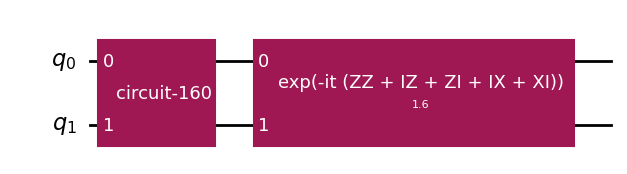

In [6]:
result.evolved_state.draw("mpl")

By sequentially decomposing the circuit, we can show it in terms of Qiskit's [Circuit Library](https://docs.quantum.ibm.com/api/qiskit/circuit_library) standard gates.

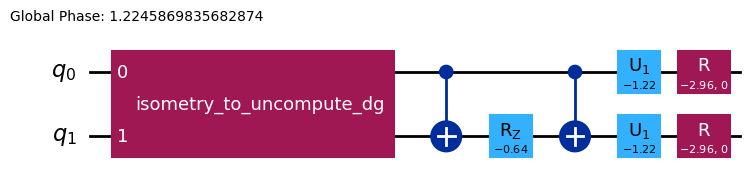

In [7]:
result.evolved_state.decompose(reps=2).decompose("disentangler_dg").decompose(
    "multiplex1_reverse_dg"
).draw("mpl")

The evolved state, like all `QuantumCircuit`s, can be turned into a `Statevector`.

In [8]:
statevector = Statevector(result.evolved_state)
print(statevector)

Statevector([ 0.02895926+0.08738739j, -0.9411211 +0.31187756j,
              0.00811432-0.002689j  ,  0.02895926+0.08738739j],
            dims=(2, 2))


Let us find out the effect of the field direction after a certain a certain time $t=1.6$. Note that the units of time are the inverse of the units of the Hamiltonian. For the purposes of this tutorial we leave all units dimensionless.

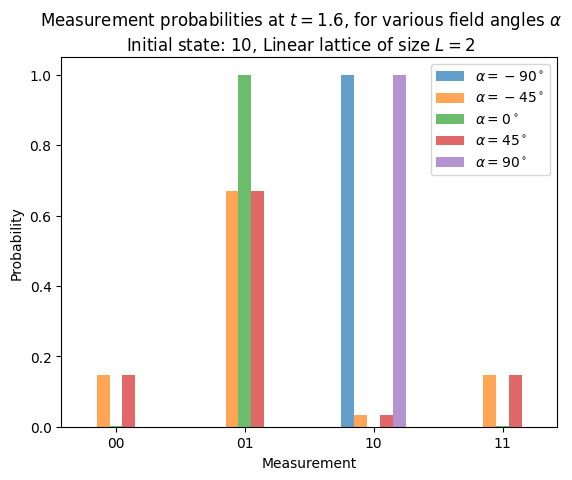

In [9]:
import numpy as np
import matplotlib.pyplot as plt

bar_width = 0.1
# We prepare an initial state ↑↓ (01).
# Note that Statevector and SparsePauliOp interpret the qubits from right to left
initial_state = Statevector.from_label("10")
trotter = TrotterQRTE()
final_time = 1.6
eps = 1e-5

# We create the list of angles in radians, with a small epsilon
# the exactly longitudinal field, which would present no dynamics at all
alphas = np.linspace(-np.pi / 2 + eps, np.pi / 2 - eps, 5)

for i, alpha in enumerate(alphas):
    H_alpha = get_hamiltonian(L=2, J=0.2, h=1.0, alpha=alpha)
    problem = TimeEvolutionProblem(H_alpha, initial_state=initial_state, time=1.6)
    result = trotter.evolve(problem)
    evolved_state = Statevector(result.evolved_state)
    # Dictionary of probabilities
    amplitudes_dict = evolved_state.probabilities_dict()
    labels = list(amplitudes_dict.keys())
    values = list(amplitudes_dict.values())
    # Convert angle to degrees
    alpha_str = f"$\\alpha={int(np.round(alpha * 180 / pi))}^\\circ$"
    plt.bar(np.arange(4) + i * bar_width, values, bar_width, label=alpha_str, alpha=0.7)

plt.xticks(np.arange(4) + 2 * bar_width, labels)
plt.xlabel("Measurement")
plt.ylabel("Probability")
plt.suptitle(
    f"Measurement probabilities at $t={final_time}$, for various field angles $\\alpha$\n"
    f"Initial state: 10, Linear lattice of size $L=2$"
)
plt.legend()

We have prepared a system initially with a sequence of spins $\uparrow\downarrow$, which corresponds to $\vert\psi(0)\rangle = \vert01\rangle$. After letting it evolve for $t=1.6$ under a transversal field ($\alpha=0^\circ$), we are almost guaranteed to measure $\downarrow\uparrow$, i.e. have a spin swap. (Note that the labels are interpreted from right to left). If the field is longitudinal ($\alpha=\pm90^\circ$), we will have no evolution, therefore we will measure the system as it was initially prepared, $\uparrow\downarrow$. With intermediate angles, at $\alpha=\pm45^\circ$, we will be able to measure all combinations will different probabilities, being a spin swap the most likely with a probability of 67%.

### Auxiliary operators

Let us look into another feature of `TrotterQRTE`. We will now explore its ability to perform time evolutions of a system, while keeping track of some observables. The system that we now consider has a size of $L=6$.

In [10]:
from math import pi

L = 6
H = get_hamiltonian(L=L, J=0.2, h=1.2, alpha=pi / 8)

The `TrotterQRTE` instance now will be created with a `num_timesteps` argument, and an `Estimator` primitive. The Qiskit's `Estimator` primitive estimates expectation values of observables, $\langle\psi\vert\hat{O}\vert\psi\rangle$.

In [11]:
from qiskit_algorithms import TrotterQRTE
from qiskit.primitives import Estimator

num_timesteps = 60
trotter = TrotterQRTE(num_timesteps=num_timesteps, estimator=Estimator())

<ipython-input-11-1ac1fa59876a>:5: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter = TrotterQRTE(num_timesteps=num_timesteps, estimator=Estimator())


Let us define a *magnetization operator* $\sum_i Z_i$, and a *mean spin correlation operator* $\sum_i Z_i Z_{i+1} / (L - 1)$.

In [12]:
magnetization_op = SparsePauliOp.from_sparse_list(
    [("Z", [i], 1.0) for i in range(0, L)], num_qubits=L
)
correlation_op = SparsePauliOp.from_sparse_list(
    [("ZZ", [i, i + 1], 1.0) for i in range(0, L - 1)], num_qubits=L
) / (L - 1)

Our new initial state will have the two middle spins facing down, and the `TimeEvolutionProblem` will incorporate some observables that will be kept track of:
1. the energy, i.e. the expectation value of the Hamiltonian, $\langle H\rangle$
2. the magnetization, $\langle \sum_i Z_i \rangle$
3. the mean spin correlation, $\langle\sum_i Z_i Z_{i+1}\rangle/(L-1)$

In [13]:
final_time = 30.0
initial_state = Statevector.from_label("001100")
problem = TimeEvolutionProblem(
    H,
    initial_state=initial_state,
    time=final_time,
    aux_operators=[H, magnetization_op, correlation_op],
)

Again, we let our `TrotterQRTE` evolve our newly created problem instance.

In [14]:
result = trotter.evolve(problem)

The new result also features an `observables` attribute. Let's extract the observables stored in it.

In [15]:
import numpy as np

observables = np.array(np.array(result.observables)[:, :, 0])
observables.shape

(61, 3)

Text(0.5, 0.98, 'Observable evolution')

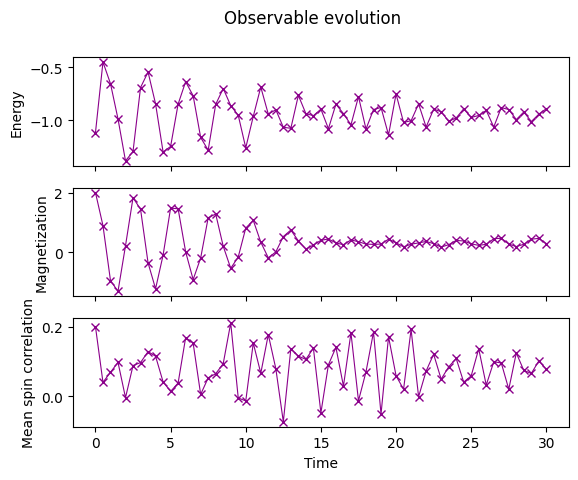

In [16]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, sharex=True)
times = np.linspace(0, final_time, num_timesteps + 1)  # includes initial state
axes[0].plot(
    times, observables[:, 0], label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[1].plot(
    times, observables[:, 1], label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[2].plot(
    times, observables[:, 2], label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[0].set_ylabel("Energy")
axes[1].set_ylabel("Magnetization")
axes[2].set_ylabel("Mean spin correlation")
axes[2].set_xlabel("Time")
fig.suptitle("Observable evolution")

Let us verify these results by comparing these expected values using Trotter evolution with the exact ones. To that end, we evaluate directly the expression discussed in the introduction,

$$
\vert \psi(t) \rangle = e^{-i H t} \vert \psi(0) \rangle \text{,}
$$

on each one of the timesteps used by Trotter. We compute this exponential using SciPy's [linalg.expm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.expm.html) function, and then we let the initial system evolve using the `Statevector`'s [evolve](https://docs.quantum.ibm.com/api/qiskit/qiskit.quantum_info.Statevector#evolve) method. This becomes too costly to be performed on larger systems very quickly.

In [17]:
import scipy as sc

H_array = H.to_matrix()

# We define a slightly denser time mesh
exact_times = np.linspace(0, final_time, 101)

# We compute the exact evolution using the exp
exact_evolution = [
    initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times
]

Having the exact state vectors, we compute the exact evolution of our operators' expectation values.

In [18]:
exact_energy = np.real([sv.expectation_value(H) for sv in exact_evolution])
exact_magnetization = np.real([sv.expectation_value(magnetization_op) for sv in exact_evolution])
exact_correlation = np.real([sv.expectation_value(correlation_op) for sv in exact_evolution])

We incorporate the exact evolution of the operators alongside the expected values resulting from the Trotterization.

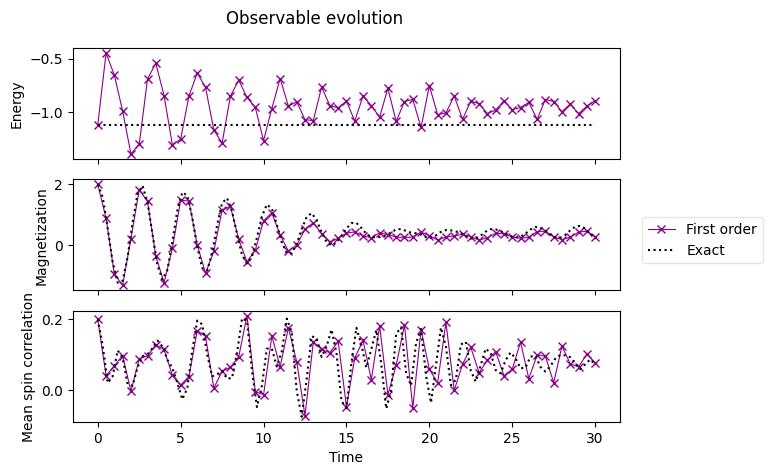

In [19]:
axes[0].plot(exact_times, exact_energy, c="k", ls=":", label="Exact")
axes[1].plot(exact_times, exact_magnetization, c="k", ls=":", label="Exact")
axes[2].plot(exact_times, exact_correlation, c="k", ls=":", label="Exact")
# Select the labels of only the first axis
legend = fig.legend(
    *axes[0].get_legend_handles_labels(),
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    framealpha=0.5,
)
fig.tight_layout()
fig

We see that, as an approximation, a Pauli-Trotter evolution isn't too far from the exact solution, but the accuracy is limited. Let's see how to find higher order formulas to address this.

### Product formula overview

If it isn't specified, the default product formula that `TrotterQRTE` uses is the Lie product formula [2], which is at first order. In Qiskit this is implemented in the [LieTrotter](https://docs.quantum.ibm.com/api/qiskit/qiskit.synthesis.LieTrotter) class. A first order formula consists of the approximation stated in the introduction, where the matrix exponential of a sum is approximated by a product of matrix exponentials:

$$
e^{A+B} \approx e^A e^B
$$

Knowing this, we can have a look at the circuit that performs a single Trotter step.


Trotter step with Lie-Trotter
-----------------------------

                  Depth: 17
             Gate count: 27
    Nonlocal gate count: 10
         Gate breakdown: CX: 10, U1: 6, R: 6, RZ: 5



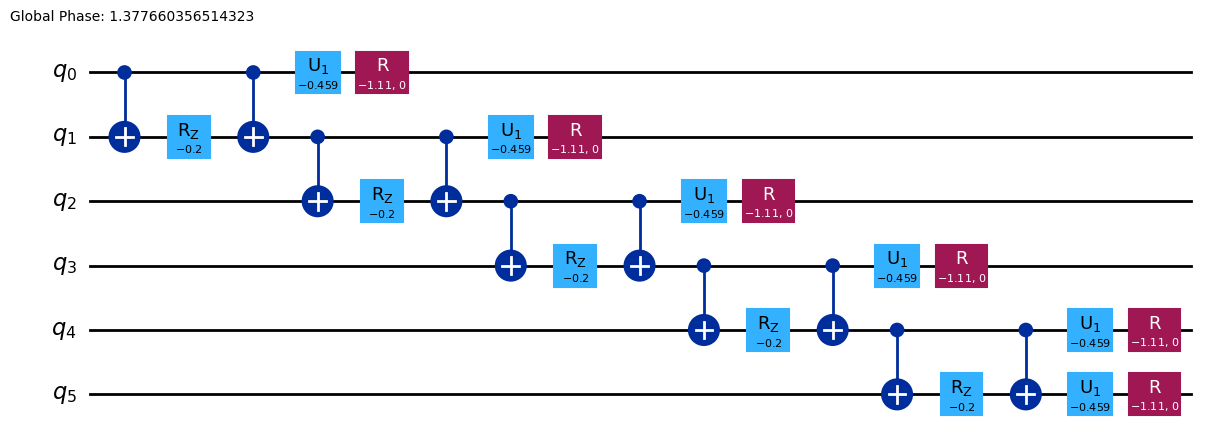

In [20]:
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter

dt = final_time / num_timesteps
trotter_step_first_order = PauliEvolutionGate(H, dt, synthesis=LieTrotter())

# We create an empty circuit
circuit = QuantumCircuit(H.num_qubits)
circuit.append(trotter_step_first_order, range(H.num_qubits))
circuit = circuit.decompose(reps=2)

# Let us print some stats
print(
    f"""
Trotter step with Lie-Trotter
-----------------------------

                  Depth: {circuit.depth()}
             Gate count: {len(circuit)}
    Nonlocal gate count: {circuit.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}
"""
)

# And finally draw the circuit
circuit.draw("mpl")

There exists a second-order formula, called the Suzuki-Trotter decomposition [3], and can be used in Qiskit by means of the [SuzukiTrotter class](https://docs.quantum.ibm.com/api/qiskit/qiskit.synthesis.SuzukiTrotter). Using this formula, a second order decomposition is:

$$
e^{A+B} \approx e^{B/2}e^{A}e^{B/2}
$$

By means of recursions, higher-order approximations can be found [1].


Trotter step with Suzuki Trotter (2nd order)
--------------------------------------------

                  Depth: 34
             Gate count: 53
    Nonlocal gate count: 20
         Gate breakdown: CX: 20, U1: 12, R: 11, RZ: 10




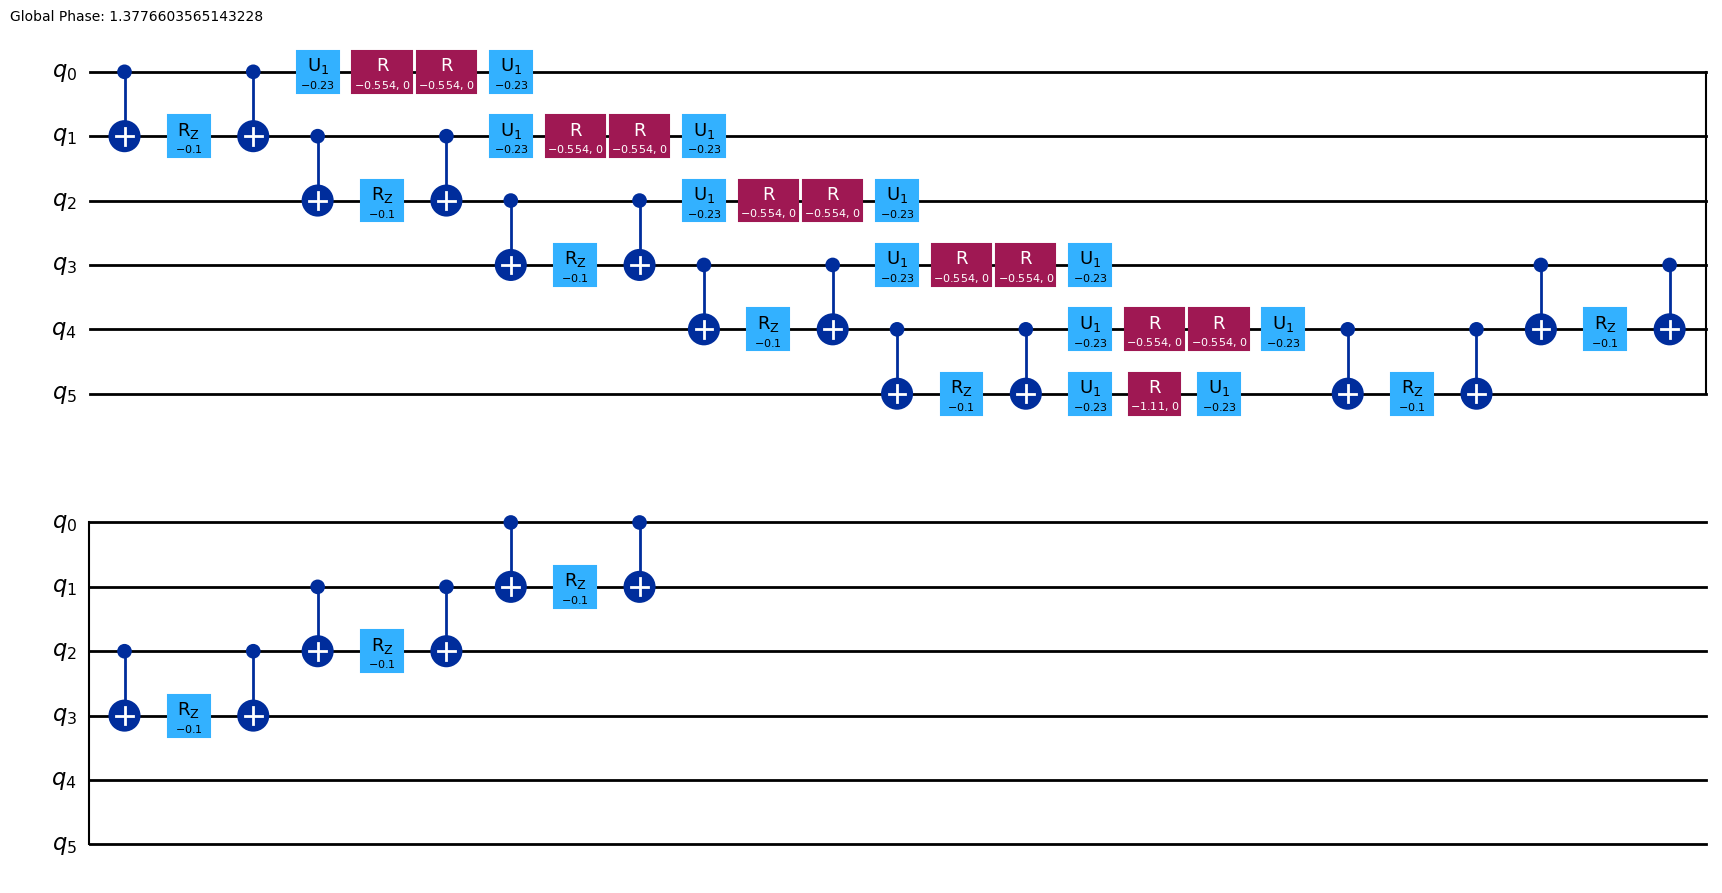

In [21]:
from qiskit.synthesis import SuzukiTrotter

second_order_formula = SuzukiTrotter()  # if not passed, order defaults to 2
trotter_step_second_order = PauliEvolutionGate(H, dt, synthesis=second_order_formula)
circuit = QuantumCircuit(H.num_qubits)
circuit.append(trotter_step_second_order, range(H.num_qubits))
circuit = circuit.decompose(reps=2)

# Let us print some stats
print(
    f"""
Trotter step with Suzuki Trotter (2nd order)
--------------------------------------------

                  Depth: {circuit.depth()}
             Gate count: {len(circuit)}
    Nonlocal gate count: {circuit.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}

"""
)

# And finall
circuit.draw("mpl")

In [22]:
fourth_order_formula = SuzukiTrotter(order=4)
trotter_step_fourth_order = PauliEvolutionGate(H, dt, synthesis=fourth_order_formula)
circuit = QuantumCircuit(H.num_qubits)
circuit.append(trotter_step_fourth_order, range(H.num_qubits))
circuit = circuit.decompose(reps=2)

# Let us print some stats
print(
    f"""
Trotter step with Suzuki Trotter (4th order)
--------------------------------------------

                  Depth: {circuit.depth()}
             Gate count: {len(circuit)}
    Nonlocal gate count: {circuit.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}

"""
)


Trotter step with Suzuki Trotter (4th order)
--------------------------------------------

                  Depth: 170
             Gate count: 265
    Nonlocal gate count: 100
         Gate breakdown: CX: 100, U1: 60, R: 55, RZ: 50




Finally, let us perform a simulation at fourth order.

In [23]:
from qiskit.synthesis import SuzukiTrotter

trotter = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=num_timesteps, estimator=Estimator())
problem = TimeEvolutionProblem(
    H,
    initial_state=initial_state,
    time=final_time,
    aux_operators=[H, magnetization_op, correlation_op],
)
result = trotter.evolve(problem)
observables_order4 = np.array(np.array(result.observables)[:, :, 0], dtype=np.float64)

<ipython-input-23-0219860d83e5>:3: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=num_timesteps, estimator=Estimator())


KeyboardInterrupt: 

and plot the results.

In [ ]:
axes[0].plot(
    times, observables_order4[:, 0], label="Fourth Order", marker="x", c="limegreen", ls="-", lw=0.8
)
axes[1].plot(
    times, observables_order4[:, 1], label="Fourth Order", marker="x", c="limegreen", ls="-", lw=0.8
)
axes[2].plot(
    times, observables_order4[:, 2], label="Fourth Order", marker="x", c="limegreen", ls="-", lw=0.8
)

# Replace the legend
legend.remove()
legend = fig.legend(
    *axes[0].get_legend_handles_labels(),
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    framealpha=0.5,
)
fig

As it is to expect, we can directly see that a higher-order product formula leads to more accurate expectation values.

### Magnetization evolution plot

In this last step, we aim at visualizing the time evolution of each one of the sites of the lattice individually. Let us present the expected value of the magnetization of each one of the sites as a function of time in a color plot. As the initial state was $\vert\psi(0)\rangle = \vert001100\rangle$ (spin sequence $\uparrow\uparrow\downarrow\downarrow\uparrow\uparrow$), at time $t=0$ we expect to see magnetization $-1$ in the two middle signs and $+1$ elsewhere. During the evolution, as the plot above suggests, we can expect to see oscillations which will eventually damp.

In [ ]:
from matplotlib import cm

# An inner list comprehension loops over the terms of the SparsePauliOp magnetization_op,
# which corresponds to the magnetization of each one of the sites
magnetizations = np.real(
    [[sv.expectation_value(term) for term in magnetization_op] for sv in exact_evolution]
)
# The shape of magnetizations is (101, 6), containing <Z>(t) for each site 0, 1, ..., 5
plt.figure(figsize=(14, 2))
# Create the 2-dim xx and yy arrays tiling the grid with the x and y values
xx, yy = np.meshgrid(exact_times, np.arange(L))
plt.pcolor(xx, yy, magnetizations.T, vmin=-1, vmax=+1, cmap="RdBu")
# Force the figure to have all y ticks from 0 to 5
plt.yticks(np.arange(L))
plt.ylabel("Site $i$")
plt.xlabel("Time")
plt.colorbar(label="$\\langle Z_i \\rangle$", aspect=1.8)

## References

[1] Hatano, Naomichi, and Masuo Suzuki. "Finding exponential product formulas of higher orders." _Quantum annealing and other optimization methods._ Berlin, Heidelberg: Springer Berlin Heidelberg, 2005. 37-68.

[2] Varadarajan, Veeravalli S. _Lie groups, Lie algebras, and their representations._ Vol. 102. Springer Science & Business Media, 2013.

[3] Magnus, Wilhelm. "On the exponential solution of differential equations for a linear operator." _Communications on pure and applied mathematics_ 7.4 (1954): 649-673.

# Lattice models

## Introduction
In quantum physics (including condensed matter physics and high energy physics) we often study models on lattices.
For example, when we think about behavior of electrons in a solid, we can study a model defined on a lattice by considering the positions of atoms as lattice points.
This notebook demonstrates how we can utilize `Lattice` classes to generate various lattice systems such as `LineLattice`, `SquareLattice`, `HyperCubicLattice`, `TriangularLattice`, and a general lattice.
It also includes an example of a lattice model, the Fermi-Hubbard model.
We see how we can define the Hamiltonian of the Fermi-Hubbard model for a given lattice using `FermiHubbardModel` class.

In [ ]:
from math import pi

import numpy as np
import rustworkx as rx
from qiskit_nature.second_q.hamiltonians.lattices import (
    BoundaryCondition,
    HyperCubicLattice,
    Lattice,
    LatticeDrawStyle,
    LineLattice,
    SquareLattice,
    TriangularLattice,
)
from qiskit_nature.second_q.hamiltonians import FermiHubbardModel

## LineLattice
`LineLattice` provides a one-dimensional lattice.
We can construct a one-dimensional lattice as follows.

In [ ]:
num_nodes = 11
boundary_condition = BoundaryCondition.OPEN
line_lattice = LineLattice(num_nodes=num_nodes, boundary_condition=boundary_condition)

Here, it is visualized.

In [ ]:
line_lattice.draw()

We can also construct a one-dimensional lattice with the periodic boundary conditions by specifying `BoundaryCondition.PERIODIC` as the argument of `boundary_condition`.

In [ ]:
num_nodes = 11
boundary_condition = BoundaryCondition.PERIODIC
line_lattice = LineLattice(num_nodes=num_nodes, boundary_condition=boundary_condition)

line_lattice.draw()

When we want to draw the lattice ignoring the boundary conditions, we use the method `draw_without_boundary`.

In [ ]:
line_lattice.draw_without_boundary()

We can define real or complex weights for the edges of the lattice.
This is done by giving a value to the argument `edge_parameter`.
We can also give a value for the self-loops of the lattice by passing the value for `onsite_parameter`.

In [ ]:
num_nodes = 11
boundary_condition = BoundaryCondition.PERIODIC
edge_parameter = 1.0 + 1.0j
onsite_parameter = 1.0
line_lattice = LineLattice(
    num_nodes=num_nodes,
    edge_parameter=edge_parameter,
    onsite_parameter=onsite_parameter,
    boundary_condition=boundary_condition,
)
set(line_lattice.graph.weighted_edge_list())

The connectivity of the lattice can be seen as the adjacency matrix, which is done by `to_adjacency_matrix`.

In [ ]:
line_lattice.to_adjacency_matrix()

By setting `weighted=True`, we obtain a Hermitian matrix whose matrix elements are the weights.

In [ ]:
line_lattice.to_adjacency_matrix(weighted=True)

## SquareLattice
`SquareLattice` provides a two-dimensional lattice.
Here, we make a two-dimensional lattice with the open boundary conditions.

In [ ]:
rows = 5
cols = 4
boundary_condition = BoundaryCondition.OPEN
square_lattice = SquareLattice(rows=rows, cols=cols, boundary_condition=boundary_condition)

square_lattice.draw()

We can specify the boundary conditions for each direction by setting `boundary_condition` as a tuple.

In [ ]:
rows = 5
cols = 4
boundary_condition = (
    BoundaryCondition.OPEN,
    BoundaryCondition.PERIODIC,
)  # open in the x-direction, periodic in the y-direction
square_lattice = SquareLattice(rows=rows, cols=cols, boundary_condition=boundary_condition)

square_lattice.draw()

Again, we can give weights on the edges and the self-loops of the lattice.
Here, it is possible to give weights for each direction as a tuple.

In [ ]:
rows = 5
cols = 4
edge_parameter = (1.0, 1.0 + 1.0j)
boundary_condition = (
    BoundaryCondition.OPEN,
    BoundaryCondition.PERIODIC,
)  # open in the x-direction, periodic in the y-direction
onsite_parameter = 1.0
square_lattice = SquareLattice(
    rows=rows,
    cols=cols,
    edge_parameter=edge_parameter,
    onsite_parameter=onsite_parameter,
    boundary_condition=boundary_condition,
)

set(square_lattice.graph.weighted_edge_list())

## HyperCubicLattice
`HyperCubicLattice` is a generalization of `LineLattice` and `SquareLattice`.
It provides an arbitrary d-dimensional lattice.
Here, we make a three-dimensional lattice of size 3 by 4 by 5 as an example.
The size is given as a tuple, and the boundary conditions can be specified for each direction too.
In the example, the boundary conditions are open.

In [ ]:
size = (3, 4, 5)
boundary_condition = (
    BoundaryCondition.OPEN,
    BoundaryCondition.OPEN,
    BoundaryCondition.OPEN,
)
cubic_lattice = HyperCubicLattice(size=size, boundary_condition=boundary_condition)

We draw the cubic lattice specifying the positions of the lattice points.

In [ ]:
# function for setting the positions
def indextocoord_3d(index: int, size: tuple, angle) -> list:
    z = index // (size[0] * size[1])
    a = index % (size[0] * size[1])
    y = a // size[0]
    x = a % size[0]
    vec_x = np.array([1, 0])
    vec_y = np.array([np.cos(angle), np.sin(angle)])
    vec_z = np.array([0, 1])
    return_coord = x * vec_x + y * vec_y + z * vec_z
    return return_coord.tolist()


pos = dict([(index, indextocoord_3d(index, size, angle=pi / 4)) for index in range(np.prod(size))])

cubic_lattice.draw(style=LatticeDrawStyle(pos=pos))

## TriangularLattice
`TriangularLattice` provides a triangular lattice, which can be seen as a two-dimensional lattice with diagonal edges.
The argument `boundary_condition` can take either "open" or "periodic".

In [ ]:
rows = 4
cols = 3
boundary_condition = BoundaryCondition.OPEN

triangular_lattice = TriangularLattice(rows=rows, cols=cols, boundary_condition=boundary_condition)

triangular_lattice.draw()

In [ ]:
rows = 4
cols = 3
boundary_condition = BoundaryCondition.PERIODIC

triangular_lattice = TriangularLattice(rows=rows, cols=cols, boundary_condition=boundary_condition)

triangular_lattice.draw()

## General Lattice
Above, we have seen translational invariant lattices.
Here, we consider a general lattice.
We can construct a general lattice consisting of nodes and edges using an instance of PyGraph.

In [ ]:
graph = rx.PyGraph(multigraph=False)  # multigraph shoud be False
graph.add_nodes_from(range(6))
weighted_edge_list = [
    (0, 1, 1.0 + 1.0j),
    (0, 2, -1.0),
    (2, 3, 2.0),
    (4, 2, -1.0 + 2.0j),
    (4, 4, 3.0),
    (2, 5, -1.0),
]
graph.add_edges_from(weighted_edge_list)

# make a lattice
general_lattice = Lattice(graph)
set(general_lattice.graph.weighted_edge_list())

Here is its visualization.

In [ ]:
general_lattice.draw()

When we want to visualize the self-loops in the lattice, we set `self_loop` to True.

In [ ]:
general_lattice.draw(self_loop=True)

The labels of the lattice sites are drawn when `with_labels` is True.

In [ ]:
general_lattice.draw(self_loop=True, style=LatticeDrawStyle(with_labels=True))

## The Fermi-Hubbard model
The Fermi-Hubbard model is the simplest model describing electrons moving on a lattice and interaction with each other at the same site.
The Hamiltonian is given as follows:

$$
H = \sum_{i, j}\sum_{\sigma = \uparrow, \downarrow} t_{i, j} c_{i, \sigma}^\dagger c_{j, \sigma} + U \sum_{i} n_{i, \uparrow} n_{i, \downarrow},
$$

where $c_{i, \sigma}^\dagger$ and $c_{i, \sigma}$ are creation and annihilation operators of fermion at the site $i$ with spin $\sigma$.
The operator $n_{i, \sigma}$ is the number operator, which is defined by $n_{i, \sigma} = c_{i, \sigma}^\dagger c_{i, \sigma}$.
The matrix $t_{i, j}$ is a Hermitian matrix called interaction matrix.
The parameter $U$ represents the strength of the interaction.

We can generate the corresponding Hamiltonian of a given lattice using `FermiHubbardModel` class.
Here, we construct the Hamiltonian with uniform interaction and interaction parameters on a two-dimensional lattice.

In [ ]:
square_lattice = SquareLattice(rows=5, cols=4, boundary_condition=BoundaryCondition.PERIODIC)

t = -1.0  # the interaction parameter
v = 0.0  # the onsite potential
u = 5.0  # the interaction parameter U

fhm = FermiHubbardModel(
    square_lattice.uniform_parameters(
        uniform_interaction=t,
        uniform_onsite_potential=v,
    ),
    onsite_interaction=u,
)

To obtain the Hamiltonian in terms of the fermionic operators, we use `second_q_ops` method.
The Hamiltonian is returned as an instance of `FermionicOp`.

- Note
    - The number of fermionic operators required is twice the number of lattice sites because of the spin degrees of freedom.
    - In the implementation, even indexes correspond to up-spin and odd indexes to down-spin.

In [ ]:
ham = fhm.second_q_op().simplify()
print(ham)

`Lattice` has weights on its edges, so we can define a general interaction matrix using a Lattice instance.
Here, we consider the Fermi-Hubbard model on a general lattice on which non-uniform interaction parameters are given.
In this case, the weights of the lattice are regarded as the interaction matrix. After generating the Hamiltonian (`second_q_ops`) we can use a qubit mapper to generate the qubit operators and/or use any of the available algorithms to solver the corresponding lattice problem.

In [ ]:
graph = rx.PyGraph(multigraph=False)  # multiigraph shoud be False
graph.add_nodes_from(range(6))
weighted_edge_list = [
    (0, 1, 1.0 + 1.0j),
    (0, 2, -1.0),
    (2, 3, 2.0),
    (4, 2, -1.0 + 2.0j),
    (4, 4, 3.0),
    (2, 5, -1.0),
]
graph.add_edges_from(weighted_edge_list)

general_lattice = Lattice(graph)  # the lattice whose weights are seen as the interaction matrix.
u = 5.0  # the interaction parameter U

fhm = FermiHubbardModel(lattice=general_lattice, onsite_interaction=u)

ham = fhm.second_q_op().simplify()
print(ham)

## Mapping to the Qubit Space

The problems and operators with which you interact in Qiskit Nature (usually) need to be mapped into the qubit space before they can be solved with our quantum algorithms. This task is handled by the various `QubitMapper` classes.

In this tutorial, you will learn about the various options available to you.

### Fermionic Mappers

This section deals with fermionic mappers, which transform fermionic operators into the qubit space.
This is mostly used by the [electronic structure stack](01_electronic_structure.ipynb) but also finds application for the [`FermiHubbardModel`](TODO).

There exist different mapping types with different properties. Qiskit Nature already supports the following fermionic mappings:

* Jordan-Wigner (Zeitschrift für Physik, 47, 631-651 (1928))
* Parity (The Journal of chemical physics, 137(22), 224109 (2012))
* Bravyi-Kitaev (Annals of Physics, 298(1), 210-226 (2002))

We will discuss some of these in the following sections. You should learn all the information necessary, to comfortable work with any of the available mappers.

In order to discuss the various mappings, we will be using the electronic structure Hamiltonian of the H2 molecule. For more information on how to obtain this, please refer to the [electronic structure tutorial](01_electronic_structure.ipynb).

#### The Jordan-Wigner Mapping

The Jordan-Wigner mapping is the most straight-forward mapping with the simplest physical interpretation, because it maps the occupation of one spin-orbital to the occupation of one qubit.

<img src="https://github.com/osbama/Phys437/blob/main/Hands-On/Hands_on_5_images/jw_mapping.png?raw=1" width="500">

You can construct use it like so:

#### The Parity Mapping

The Parity mapping is the dual mapping to the Jordan-Wigner one, in the sense that it encodes the parity information locally on one qubit, whereas the occupation information is delocalized over all qubits.

This has one major benefit for the case of problems in which we want to preserve the number of particles of each spin species; it allows us to remove 2 qubits, because the information in them becomes redundant.
Since Qiskit Nature arranges the qubits in block-order, such that the first half encodes the alpha-spin, and the second half the beta-spin information, this means we can remove the N/2-th and N-th qubit.

To do this, you need to specify the number of particles in your system, like so:

#### More advanced qubit reductions

It is also possible to perform more advanced qubit reductions, which are based on finding Z2 symmetries in the Hilbert space of the qubit. A requirement for this to be useful, is that you know in which symmetry-subspace you need to look for your actual solution of interest. This can be a bit tricky, but luckily the problem classes of Qiskit Nature provide you with a utility to automatically determine that correct subspace.



#### Interleaved ordering

As mentioned previously, Qiskit Nature arranges the fermionic spin-up and spin-down parts of the qubit register in block-order. However, sometimes one may want to interleave the registers instead. This can be achieved by means of the `InterleavedQubitMapper`.

## LatticeModelProblem
Qiskit Nature also has a `LatticeModelProblem` class which allows the usage of the `GroundStateEigensolver` to calculate the ground state energy of a given lattice. You can use this class as follows:

In [ ]:
from qiskit_nature.second_q.problems import LatticeModelProblem

num_nodes = 4
boundary_condition = BoundaryCondition.OPEN
line_lattice = LineLattice(num_nodes=num_nodes, boundary_condition=boundary_condition)

fhm = FermiHubbardModel(
    line_lattice.uniform_parameters(
        uniform_interaction=t,
        uniform_onsite_potential=v,
    ),
    onsite_interaction=u,
)

lmp = LatticeModelProblem(fhm)

In [ ]:
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper

numpy_solver = NumPyMinimumEigensolver()

qubit_mapper = JordanWignerMapper()

calc = GroundStateEigensolver(qubit_mapper, numpy_solver)
res = calc.solve(lmp)

print(res)

# Quadratic Hamiltonians and Slater determinants

A quadratic Hamiltonian is a Hamiltonian of the form
$$
    H =
    \sum_{j, k} M_{jk} a^\dagger_j a_k
    + \frac12 \sum_{j, k}
        (\Delta_{jk} a^\dagger_j a^\dagger_k + \Delta^*_{jk} a_k a_j)
    + \text{constant}
$$
where $M$ is a Hermitian matrix ($M^\dagger = M$) and $\Delta$ is an antisymmetric matrix ($\Delta^T = -\Delta$), and the $\{a_j^\dagger\}$ are fermionic creation operators which satisfy the anticommutation relations
$$
    \begin{align}
        a_j a_k + a_k a_j &= 0 \\
        a_j a^\dagger_k + a^\dagger_k a_j &= \delta_{pq}
    \end{align}.
$$

Quadratic Hamiltonians are an important class of Hamiltonians that are classically tractable. Their eigenstates are called fermionic Gaussian states, and they can be efficiently prepared on a quantum computer. Qiskit Nature includes the `QuadraticHamiltonian` class for representing quadratic Hamiltonians.

Of course, the `FermionicOp` class can also be used to represent any quadratic Hamiltonian. The reason to have a class specifically for quadratic Hamiltonians is that they support special numerical routines that involve performing linear algebra on the matrices $M$ and $\Delta$. The internal representation format of `FermionicOp` is not suitable for these routines.

A quadratic Hamiltonian is initialized like so:

In [ ]:
import numpy as np
from qiskit_nature.second_q.hamiltonians import QuadraticHamiltonian

# create Hamiltonian
hermitian_part = np.array(
    [
        [1.0, 2.0, 0.0, 0.0],
        [2.0, 1.0, 2.0, 0.0],
        [0.0, 2.0, 1.0, 2.0],
        [0.0, 0.0, 2.0, 1.0],
    ]
)
antisymmetric_part = np.array(
    [
        [0.0, 3.0, 0.0, 0.0],
        [-3.0, 0.0, 3.0, 0.0],
        [0.0, -3.0, 0.0, 3.0],
        [0.0, 0.0, -3.0, 0.0],
    ]
)
constant = 4.0

hamiltonian = QuadraticHamiltonian(
    hermitian_part=hermitian_part,
    antisymmetric_part=antisymmetric_part,
    constant=constant,
)

# convert it to a FermionicOp and print it
hamiltonian_ferm = hamiltonian.second_q_op()
print(hamiltonian_ferm)

## Diagonalization and state preparation
A quadratic Hamiltonian can always be rewritten in the form
$$
    H = \sum_{j} \varepsilon_j b^\dagger_j b_j + \text{constant}
$$
where $\varepsilon_0 \leq \varepsilon_1 \leq \cdots \leq \varepsilon_N$ are non-negative real numbers called orbitals energies and
the $\{b_j^\dagger\}$ are a new set of fermionic creation operators
that also satisfy the canonical anticommutation relations.
These new creation operators are linear combinations of the original creation and annihilation operators:
$$
    \begin{pmatrix}
    b^\dagger_1 \\
    \vdots \\
    b^\dagger_N \\
    \end{pmatrix}
    = W
    \begin{pmatrix}
    a^\dagger_1 \\
    \vdots \\
    a^\dagger_N \\
    a_1 \\
    \vdots \\
    a_N
    \end{pmatrix},
$$
where $W$ is an $N \times 2N$ matrix. Given a basis of eigenvectors of the Hamiltonian, each eigenvector is labeled by a subset of $\{0, \ldots, N - 1\}$, which we call the occupied orbitals. The corresponding eigenvalue is the sum of the corresponding values of $\varepsilon_j$, plus the constant.

In [ ]:
# get the transformation matrix W and orbital energies {epsilon_j}
(
    transformation_matrix,
    orbital_energies,
    transformed_constant,
) = hamiltonian.diagonalizing_bogoliubov_transform()

print(f"Shape of matrix W: {transformation_matrix.shape}")
print(f"Orbital energies: {orbital_energies}")
print(f"Transformed constant: {transformed_constant}")

The transformation matrix $W$ is used to construct a circuit to prepare an eigenvector of the Hamiltonian. The circuit is constructed using the `FermionicGaussianState` class. Currently, only the [Jordan-Wigner Transform](https://qiskit-community.github.io/qiskit-nature/stubs/qiskit_nature.second_q.mappers.JordanWignerMapper.html)
is supported. The circuit for the Jordan-Wigner Transform has linear depth and uses only linear qubit connectivity. The algorithm is from [Phys. Rev. Applied 9, 044036](https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.9.044036).

In [ ]:
from qiskit_nature.second_q.circuit.library import FermionicGaussianState

occupied_orbitals = (0, 2)
eig = np.sum(orbital_energies[list(occupied_orbitals)]) + transformed_constant
print(f"Eigenvalue: {eig}")

circuit = FermionicGaussianState(transformation_matrix, occupied_orbitals=occupied_orbitals)
circuit.draw("mpl")

The following code cell simulates the circuit and verifies that the output state is indeed an eigenstate of the Hamiltonian with the expected eigenvalue.

In [ ]:
from qiskit.quantum_info import Statevector
from qiskit_nature.second_q.mappers import JordanWignerMapper

# simulate the circuit to get the final state
state = np.array(Statevector(circuit))

# convert the Hamiltonian to a matrix
hamiltonian_jw = JordanWignerMapper().map(hamiltonian_ferm).to_matrix()

# check that the state is an eigenvector with the expected eigenvalue
np.testing.assert_allclose(hamiltonian_jw @ state, eig * state, atol=1e-8)

## Slater determinants

When the antisymmetric part $\Delta = 0$, then the Hamiltonian conserves the number of particles. In this case, the basis change only needs to mix creation operators, not annihilation operators:
$$
    \begin{pmatrix}
    b^\dagger_1 \\
    \vdots \\
    b^\dagger_N \\
    \end{pmatrix}
    = W
    \begin{pmatrix}
    a^\dagger_1 \\
    \vdots \\
    a^\dagger_N \\
    \end{pmatrix},
$$
where now $W$ is an $N \times N$ matrix. Furthermore, the orbital energies $\{\varepsilon_j\}$ are allowed to be negative.

In [ ]:
# create Hamiltonian
hermitian_part = np.array(
    [
        [1.0, 2.0, 0.0, 0.0],
        [2.0, 1.0, 2.0, 0.0],
        [0.0, 2.0, 1.0, 2.0],
        [0.0, 0.0, 2.0, 1.0],
    ]
)
constant = 4.0

hamiltonian = QuadraticHamiltonian(
    hermitian_part=hermitian_part,
    constant=constant,
)

print(f"Hamiltonian conserves particle number: {hamiltonian.conserves_particle_number()}")

In [ ]:
# get the transformation matrix W and orbital energies {epsilon_j}
(
    transformation_matrix,
    orbital_energies,
    transformed_constant,
) = hamiltonian.diagonalizing_bogoliubov_transform()

print(f"Shape of matrix W: {transformation_matrix.shape}")
print(f"Orbital energies: {orbital_energies}")
print(f"Transformed constant: {transformed_constant}")

In this special case, the eigenstates are called Slater determinants, and a more efficient algorithm is used to prepare them. This algorithm is accessed by using the `SlaterDeterminant` class instead of `FermionicGaussianState`. `SlaterDeterminant` does not take the occupied orbitals as input. Instead, the shape of the transformation matrix is allowed to vary. It should be an $\eta \times N$ matrix where $\eta$ is the number of particles.

In [ ]:
from qiskit_nature.second_q.circuit.library import SlaterDeterminant

occupied_orbitals = (0, 2)
eig = np.sum(orbital_energies[list(occupied_orbitals)]) + transformed_constant
print(f"Eigenvalue: {eig}")

circuit = SlaterDeterminant(transformation_matrix[list(occupied_orbitals)])
circuit.draw("mpl")

## Time evolution

Time evolution under a quadratic Hamiltonian can be easily performed by changing into the diagonal basis of the Hamiltonian. The state preparation circuits shown above effect this basis change, but they are optimized for state preparation from a computational basis state (assumed to be the all zeros state), and they do not work on arbitrary states. The general unitary basis change which does work on arbitrary states is called the Bogoliubov transform, and it is also implemented in Qiskit Nature.

The code block below demonstrates the use of the Bogoliubov transform to implement time evolution for a quadratic Hamiltonian.

In [ ]:
from qiskit_nature.second_q.circuit.library import BogoliubovTransform
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import random_hermitian, random_statevector, state_fidelity
from scipy.linalg import expm

# create Hamiltonian
n_modes = 5
hermitian_part = np.array(random_hermitian(n_modes))
hamiltonian = QuadraticHamiltonian(hermitian_part=hermitian_part)

# diagonalize Hamiltonian
(
    transformation_matrix,
    orbital_energies,
    _,
) = hamiltonian.diagonalizing_bogoliubov_transform()

# set simulation time and construct time evolution circuit
time = 1.0
register = QuantumRegister(n_modes)
circuit = QuantumCircuit(register)
bog_circuit = BogoliubovTransform(transformation_matrix)
# change to the diagonal basis of the Hamiltonian
circuit.append(bog_circuit.inverse(), register)
# perform time evolution by applying z rotations
for q, energy in zip(register, orbital_energies):
    circuit.rz(-energy * time, q)
# change back to the original basis
circuit.append(bog_circuit, register)

# simulate the circuit
initial_state = random_statevector(2**n_modes)
final_state = initial_state.evolve(circuit)

# compute the correct state by direct exponentiation
hamiltonian_jw = JordanWignerMapper().map(hamiltonian.second_q_op()).to_matrix()
exact_evolution_op = expm(-1j * time * hamiltonian_jw)
expected_state = exact_evolution_op @ np.array(initial_state)

# check that the simulated state is correct
fidelity = state_fidelity(final_state, expected_state)
print ("Fidelity:",fidelity)

# Midterm take home programming part

Define a periodic line lattice with four nodes. Use Jordan-Wigner mapper to qubitize Fermi-Hubbard model. Use the same mapper to create a half filled state (i.e. first two nodes are filled, rest are empty). Trotterize using SuzukiTrotter. Define an operator that gives you the total charge at each site. Evolve. Try regimes where v=0 U~0.1v U~1v U~10v (keep t=-1). Do you see any differences in behaviour?  

In [31]:
import numpy as np
from qiskit_nature.second_q.hamiltonians import FermiHubbardModel
from qiskit_nature.second_q.hamiltonians.lattices import LineLattice, BoundaryCondition
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.problems import LatticeModelProblem
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter
from qiskit import QuantumCircuit
import matplotlib.pyplot as plt
from qiskit.quantum_info import SparsePauliOp

num_nodes = 4
boundary_condition = BoundaryCondition.PERIODIC
line_lattice = LineLattice(num_nodes=num_nodes, boundary_condition=boundary_condition)


t = -1.0
v = 0.0
u_values = [0.1 * abs(t), 1.0 * abs(t), 10.0 * abs(t)]


fhm = FermiHubbardModel(
    line_lattice.uniform_parameters(uniform_interaction=t, uniform_onsite_potential=v),
    onsite_interaction=0.0,
)


jw_mapper = JordanWignerMapper()
hamiltonian = jw_mapper.map(fhm.second_q_op())

half_filled_state = Statevector.from_label("1100")

time = 10.0
num_timesteps = 100  #
dt = time / num_timesteps


def create_trotter_circuit(hamiltonian, u_value):
    fhm.onsite_interaction = u_value
    hamiltonian = jw_mapper.map(fhm.second_q_op())

    trotter_step = PauliEvolutionGate(hamiltonian, dt, synthesis=SuzukiTrotter())

    circuit = QuantumCircuit(hamiltonian.num_qubits)
    for _ in range(num_timesteps):
        circuit.append(trotter_step, range(hamiltonian.num_qubits))

    return circuit




pauli_strings = ["Z" + "I" * (num_nodes - 1 - i) + "I" * i for i in range(num_nodes)]
coefficients = [1.0] * num_nodes

charge_operator = SparsePauliOp(pauli_strings, coefficients)


results = {}
for u_value in u_values:
    fhm.onsite_interaction = u_value
    hamiltonian = jw_mapper.map(fhm.second_q_op())


    trotter_step = PauliEvolutionGate(hamiltonian, dt, synthesis=SuzukiTrotter())


    num_qubits = hamiltonian.num_qubits
    circuit = QuantumCircuit(num_qubits)

    half_filled_state = Statevector.from_label("1" * (num_qubits // 2) + "0" * (num_qubits - num_qubits // 2))

    # Apply Trotter steps
    for _ in range(num_timesteps):
        circuit.append(trotter_step, range(num_qubits))

    evolved_state = half_filled_state.evolve(circuit)

    charges = np.real([evolved_state.expectation_value(charge_operator)])

    results[u_value] = charges

for u_value, charges in results.items():
    print(u_value,charges)



0.1 [1.67993131]
1.0 [1.67993131]
10.0 [1.67993131]
